### Model Assumptions
- One preselected stop per neighborhood
- One bus
- One school
- Start and end at school
- Each stop must be visited once
- Not accounting for walking distances yet, just bus travel times
- Not accounting for operational costs because only one bus 
- Infinite capacity on bus


In [1]:
from gurobipy import *
import numpy as np
import pandas as pd

### Data

In [2]:
# Population at stops
minadeo = pd.read_csv('minadeo_stops_all.csv')
pop = list(minadeo.sort_values('STOP_ID')['NUM_KIDS'])

# Initial number of kids
initial_kids = sum(pop)

# Total number of segments
max_segments = len(pop)


# Travel times between stops 
tt = pd.read_csv('distance_matrix.csv')

tt.Distance = (tt.Distance/1609.344)*(60.0/30.0) # convert from meters to minutes

# Function to get stop distances
def get_distance(i,j):
    if i==j:
        return(0)
    else:
        try:
            d = tt.loc[(tt.InputID==i)&(tt.TargetID==j),'Distance'].iloc[0]
            return(d)
        except:
            print('No distance found for i={},j={}'.format(i,j))

### Indeces

In [3]:
stops = range(len(pop))
segments = range(max_segments)

### Setting up Model

In [4]:
m = Model("Last Mile Model 1")

Using license file /Users/matty_sam/gurobi.lic
Academic license - for non-commercial use only


### Decision Variables

In [5]:
# Binary variable for whether to go from stop i to j at segment s
y = m.addVars(stops, stops, segments, 
              lb = 0.0, vtype = GRB.BINARY)

# Auxiliary variable for how many students are on bus at a segment
b = m.addVars(segments, lb = 0.0, vtype = GRB.INTEGER)

### Objective Function

In [6]:
# The objective is to minimize total time students spend on the bus

total_travel = LinExpr()

for i in stops:
    for j in stops:
        for s in segments:
            total_travel += b[s] * get_distance(i,j) * y[i,j,s]
            
m.setObjective(total_travel, GRB.MINIMIZE)

### Constraints

In [7]:
# Kids on bus continuity constraint
for s in segments:
    m.addConstr(b[s] == initial_kids -
               sum(sum(sum(y[i,j,z] * pop[j] for z in range(s))
                                             for j in stops)
                                             for i in stops))
# Continuous route
for a in stops:
    for s in range(0, max(segments)):
        m.addConstr((sum(y[a,j,s+1] for j in stops) - 
                     sum(y[i,a,s] for i in stops)) == 0)

# # Start at school constraint
m.addConstr(sum(y[0,j,0] for j in stops) == 1)
                
# Every stop is visited once constraint
for j in stops:
    m.addConstr(sum(sum(y[i,j,s] for s in segments)
                                 for i in stops) == 1)
    
# # Every stop is left once constraint
for i in stops:
    m.addConstr(sum(sum(y[i,j,s] for s in segments)
                                 for j in stops) == 1)
    
# Cannot have same origin and destination constraint
for i in stops:
    for s in segments:
        m.addConstr(y[i,i,s] == 0)

### Solve

In [8]:
m.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 265 rows, 1342 columns and 11275 nonzeros
Model fingerprint: 0x99bca551
Model has 1210 quadratic objective terms
Variable types: 0 continuous, 1342 integer (1331 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 133 rows and 322 columns
Presolve time: 0.06s
Presolved: 1042 rows, 1930 columns, 10799 nonzeros
Variable types: 0 continuous, 1930 integer (1010 binary)
Found heuristic solution: objective 5771.2410586

Root relaxation: objective 1.667647e+02, 401 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  166.76470    0   57 5771.24106  166.76470  97.1%     -    0s
H    0     0                    4003.9560

In [9]:
total_travel.getValue()

1472.036601139595

In [10]:
pop

[0, 6, 35, 78, 11, 13, 58, 5, 29, 9, 6]

In [11]:
kids_on_bus = list()

for s in segments:
    for i in stops:
        for j in stops:
            if y[i,j,s].x == 1:
                print("kids on bus: ", b[s].x)
                kids_on_bus.append(b[s].x)

kids on bus:  250.0
kids on bus:  239.0
kids on bus:  161.0
kids on bus:  155.0
kids on bus:  97.0
kids on bus:  62.0
kids on bus:  49.0
kids on bus:  20.0
kids on bus:  11.0
kids on bus:  5.0
kids on bus:  0.0


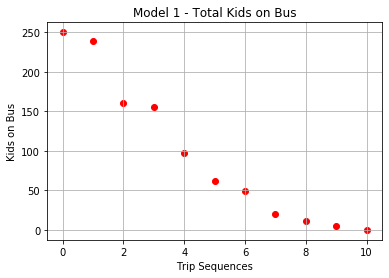

In [15]:
# Graphing outcomes
import matplotlib.pyplot as plt

plt.scatter(range(len(kids_on_bus)), kids_on_bus, color = 'r')
plt.xlabel('Trip Sequences')
plt.ylabel('Kids on Bus')
plt.title('Model 1 - Total Kids on Bus')
plt.grid()
plt.show()

In [13]:
for s in segments:
    for i in stops:
        for j in stops:
            if y[i,j,s].x == 1:
                print("segment ", s, ": ", i, " -> ", j)

segment  0 :  0  ->  4
segment  1 :  4  ->  3
segment  2 :  3  ->  1
segment  3 :  1  ->  6
segment  4 :  6  ->  2
segment  5 :  2  ->  5
segment  6 :  5  ->  8
segment  7 :  8  ->  9
segment  8 :  9  ->  10
segment  9 :  10  ->  7
segment  10 :  7  ->  0


In [14]:
k = initial_kids # kids left
kids_left = []
kid_time = []
for s in segments:
    for i in stops:
        for j in stops:
            if y[i,j,s].x == 1:
                print('seg {} : {} --> {}'.format(s,i,j))
                k += (-1) * pop[i] * y[i,j,s].x
                travel_seg = k*get_distance(i,j)
                print('{} kids were on bus, {} get off'.format(k, pop[i]))
                print('From {} to {} takes {}, {} kid time on segment {}'.format(i,j,get_distance(i,j),travel_seg, s))
                kids_left.append(k)
                kid_time.append(travel_seg)

seg 0 : 0 --> 4
250.0 kids were on bus, 0 get off
From 0 to 4 takes 0.5074128539330311, 126.85321348325779 kid time on segment 0
seg 1 : 4 --> 3
239.0 kids were on bus, 11 get off
From 4 to 3 takes 1.9079068589437682, 455.9897392875606 kid time on segment 1
seg 2 : 3 --> 1
161.0 kids were on bus, 78 get off
From 3 to 1 takes 1.0778266762109283, 173.53009486995947 kid time on segment 2
seg 3 : 1 --> 6
155.0 kids were on bus, 6 get off
From 1 to 6 takes 2.4221121164897004, 375.42737805590355 kid time on segment 3
seg 4 : 6 --> 2
97.0 kids were on bus, 58 get off
From 6 to 2 takes 1.1819866872464806, 114.65270866290862 kid time on segment 4
seg 5 : 2 --> 5
62.0 kids were on bus, 35 get off
From 2 to 5 takes 1.7829584936471008, 110.54342660612025 kid time on segment 5
seg 6 : 5 --> 8
49.0 kids were on bus, 13 get off
From 5 to 8 takes 1.7748911730493915, 86.96966747942018 kid time on segment 6
seg 7 : 8 --> 9
20.0 kids were on bus, 29 get off
From 8 to 9 takes 0.9204314755577427, 18.408629